In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2

# Task 4

In [27]:
def harris_corner_detection(image, k=0.04, threshold=0.01, nms_window_size=5):

    # He took this simple idea to a mathematical form. It basically finds the
    # difference in intensity for a displacement of (u,v) in all directions

    # E(u,v) = Σ Σ w(x,y) [I(x+u, y+v) - I(x,y)]^2 ; with w being the window function, and I is the intensity
    # The window function is either a rectangular window or a Gaussian window which gives weights to pixels underneath.
    # we need to maximize this E(u,v) function.


    # Convert the image to float32
    gray = np.float32(image)
    
    # # Compute Harris corner response
    # dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=k)
    
    # Compute gradients
    Ix = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    Iy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute products of derivatives
    Ixx = Ix * Ix
    Iyy = Iy * Iy
    Ixy = Ix * Iy
    
    
    # Compute the sums of the products of derivatives at each pixel
    Sxx = cv2.GaussianBlur(Ixx, (3, 3), 1)
    Syy = cv2.GaussianBlur(Iyy, (3, 3), 1)
    Sxy = cv2.GaussianBlur(Ixy, (3, 3), 1)
    
    # Compute the response of the detector at each pixel
    det = (Sxx * Syy) - (Sxy * Sxy)
    trace = Sxx + Syy
    dst = det - k * (trace ** 2)
    
    
    
    # Normalize the corner response
    # dst = np.empty(dst.shape, dtype=np.float32)
    # dst = cv2.normalize(dst, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    
    # Apply threshold and non-maximum suppression
    corners = np.zeros_like(dst)
    h, w = dst.shape
    for i in range(h):
        for j in range(w):
            if int(dst[i,j]) > threshold * dst.max():
                # Apply non-maximum suppression
                window = dst[max(0, i-nms_window_size//2):min(h, i+nms_window_size//2+1),
                                  max(0, j-nms_window_size//2):min(w, j+nms_window_size//2+1)]
                if dst[i,j] == window.max():
                    corners[i,j] = 255
    
    
    
    # Dilate corners for better visibility
    corners = cv2.dilate(corners, None)
    
    # Create a color image to mark corners
    marked_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    
    # Mark corners on the original image
    marked_image[corners > 0.01 * corners.max()] = [0, 0, 255]  # Red color
    
    return marked_image, corners

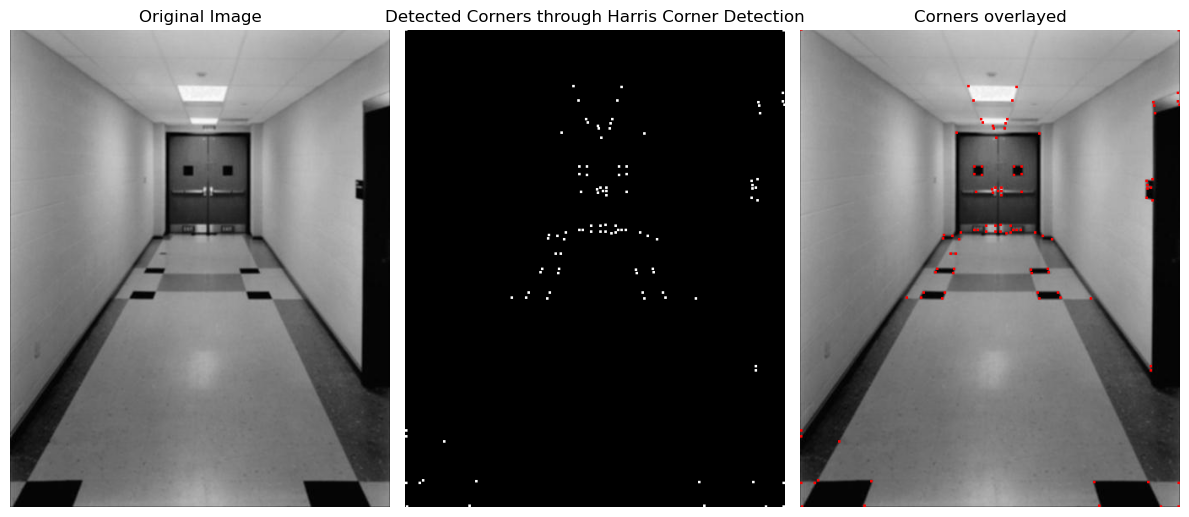

In [28]:
# Load the image
# image_path = './images/chessboard.jpg' 
# chessboard_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

image_path = './images/hallway.jpg' 
hallway_image = cv2.imread(image_path, cv2.IMREAD_COLOR)

result, corners = harris_corner_detection(cv2.cvtColor(hallway_image, cv2.COLOR_BGR2GRAY),  k=0.04, threshold=0.01, nms_window_size=5)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(hallway_image[...,::-1])
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(corners, cmap='gray')
plt.title('Detected Corners through Harris Corner Detection'), plt.axis('off')
plt.subplot(133), plt.imshow(result[...,::-1])
plt.title('Corners overlayed'), plt.axis('off')
plt.tight_layout()
plt.show()


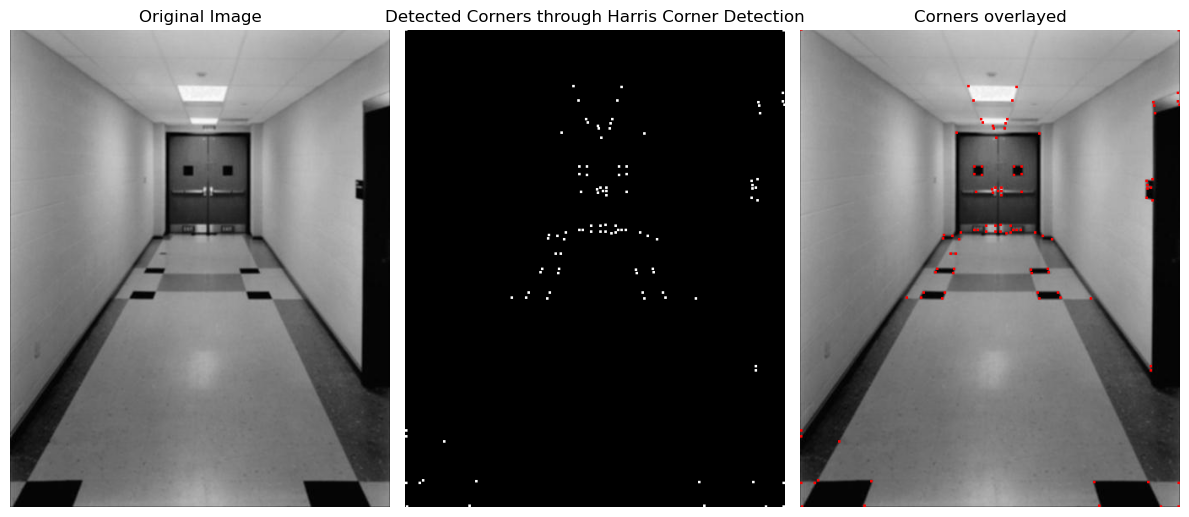

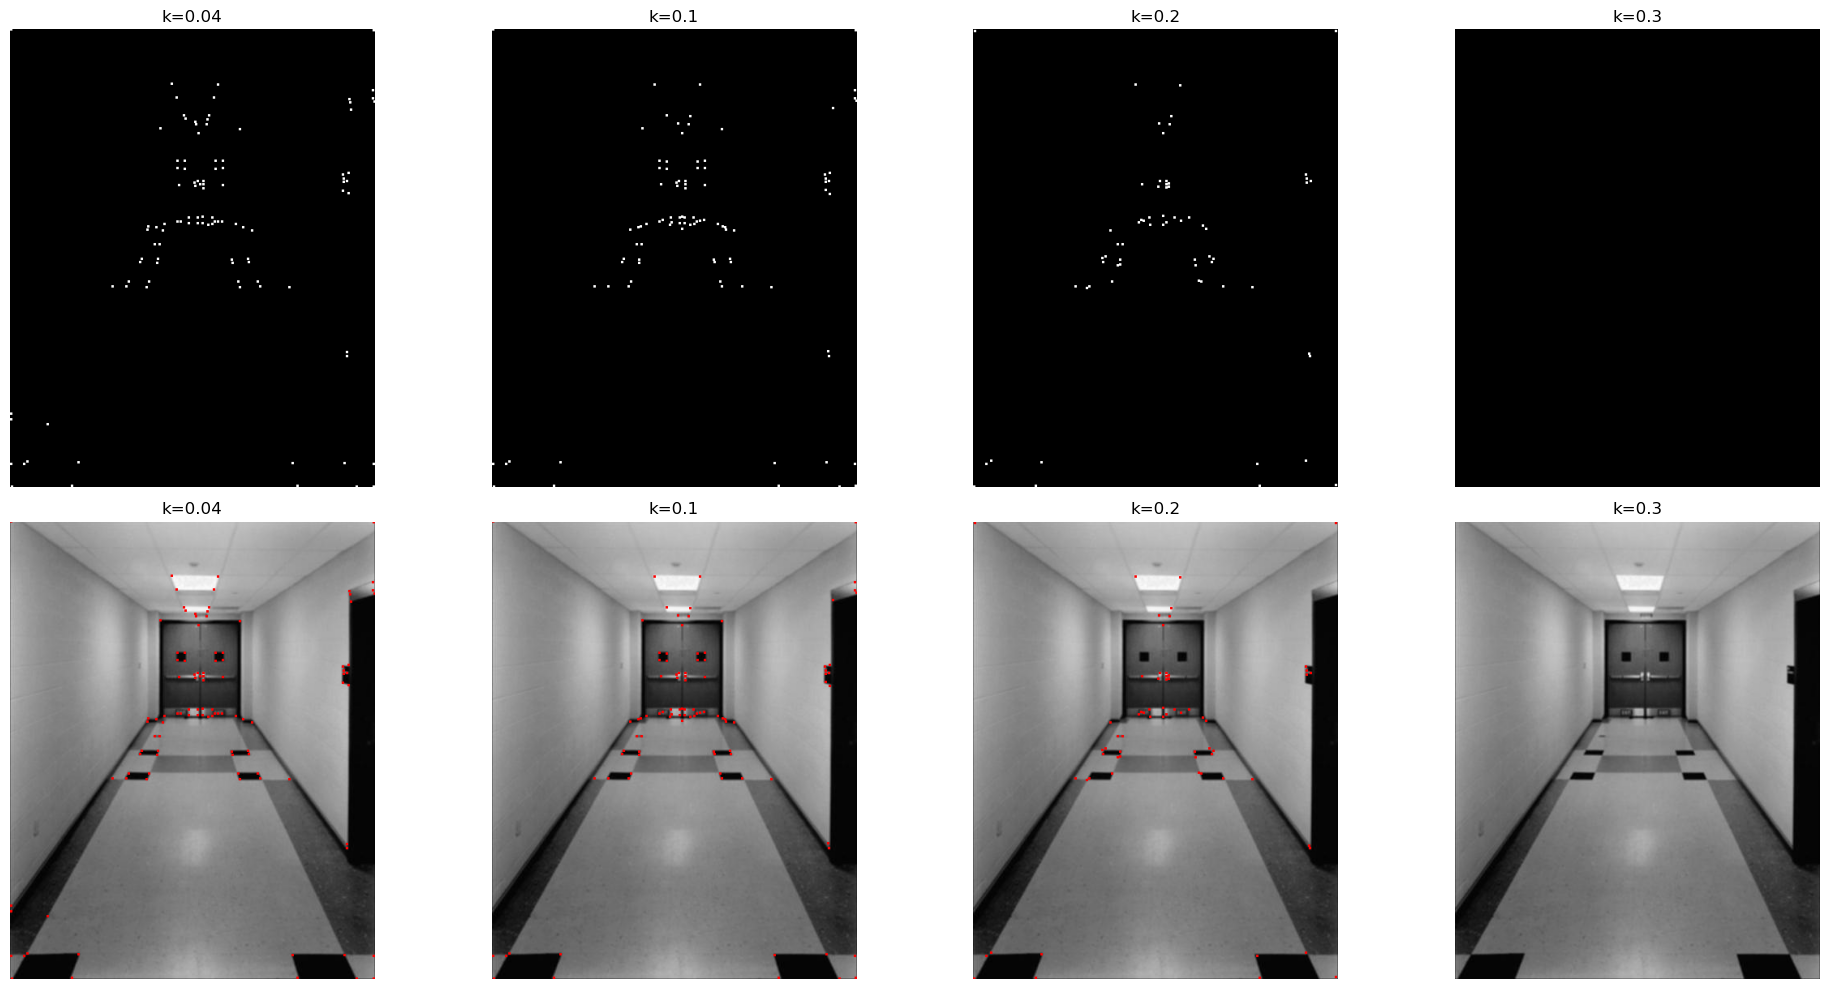

In [30]:
result, corners = harris_corner_detection(cv2.cvtColor(hallway_image, cv2.COLOR_BGR2GRAY),  k=0.04, threshold=0.01, nms_window_size=5)

# Display the results
plt.figure(figsize=(12, 6))
plt.subplot(131), plt.imshow(hallway_image[...,::-1])
plt.title('Original Image'), plt.axis('off')
plt.subplot(132), plt.imshow(corners, cmap='gray')
plt.title('Detected Corners through Harris Corner Detection'), plt.axis('off')
plt.subplot(133), plt.imshow(result[...,::-1])
plt.title('Corners overlayed'), plt.axis('off')
plt.tight_layout()
plt.show()
# Vary the sensitivity parameter k and observe the results
k_values = [0.04, 0.1, 0.2, 0.3]
fig, axes = plt.subplots(2, len(k_values), figsize=(20, 10))

for idx, k in enumerate(k_values):
    result, corners = harris_corner_detection(cv2.cvtColor(hallway_image, cv2.COLOR_BGR2GRAY), k=k, threshold=0.01, nms_window_size=5)
    
    axes[0, idx].imshow(corners, cmap='gray')
    axes[0, idx].set_title(f'k={k}')
    axes[0, idx].axis('off')
    
    axes[1, idx].imshow(result[...,::-1])
    axes[1, idx].set_title(f'k={k}')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.show()

It is a constant used in the calculation of the corner response function, influencing how much emphasis is placed on corner-like regions versus edge-like or flat regions. Typically, k is a value between 0.04 and 0.06. A lower k leads to more corners being detected, including noise, while a higher k makes the detector more selective, detecting only the most prominent corners and ignoring weak ones

Higher k => higher sensitivity => only prominent conners detected


This can also be seen in our results where the k=0.04 detected the 4 corners of the ceiling lamp, but k = 0.1 detected only 1. and even k = 0.1 detected  the corners in the door's black box, but k = 0.2 failed to do so. And k = 0.3 didnt detect anything

# Task 5

## Parameter Space

- **Line Detection**: The Hough Transform for lines operates in a two-dimensional parameter space. Each line can be represented in polar coordinates as $\rho = x \cos(\theta) + y \sin(\theta)$, where $\rho$ is the distance from the origin to the line and $\theta$ is the angle of the line. Each edge point in the image contributes to a sinusoidal curve in this space, and intersections of these curves indicate potential lines.

- **Circle Detection**: In contrast, circle detection requires a three-dimensional parameter space defined by the center coordinates $(x_{center}, y_{center})$ and radius $r$. For each edge point, a sphere is formed in this space, where the radius varies. The accumulator matrix collects votes for potential circles, with local maxima indicating detected circles.

## Computational Complexity

The computational complexity differs notably between the two applications:

- **Lines**: The two-dimensional nature of line detection leads to lower computational demands. The algorithm typically involves fewer calculations, making it faster and less memory-intensive.

- **Circles**: Circle detection's three-dimensional parameter space increases complexity significantly. The algorithm must evaluate multiple radii for each edge point, leading to higher computational overhead. This results in longer processing times and greater memory requirements due to the larger accumulator matrix needed to store votes for various circle parameters.

In summary, while both applications utilize the Hough Transform's voting mechanism, line detection is simpler and more efficient compared to the more complex and resource-intensive process required for circle detection.
